In [9]:
# CSS style setting
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

# Import Toolkits

In [10]:
import os
import itertools
import shutil
import pathlib
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Prepare Data

In [11]:
data_path = '/kaggle/input/5-flower-types-classification-dataset/flower_images'
filepath = []
label = []

folds = os.listdir(data_path)

for fold in folds:
    foldpath = os.path.join(data_path , fold)
    files = os.listdir(foldpath)
    
    for file in files:
        file_path = os.path.join(foldpath , file)
        filepath.append(file_path)
        label.append(fold)
        

        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepath')
lseries = pd.Series(label , name= 'labels')
df = pd.concat([fseries ,lseries ] , axis= 1)

df

,filepath,labels
0,/kaggle/input/5-flower-types-classification-da...,Orchid
1,/kaggle/input/5-flower-types-classification-da...,Orchid
2,/kaggle/input/5-flower-types-classification-da...,Orchid
3,/kaggle/input/5-flower-types-classification-da...,Orchid
4,/kaggle/input/5-flower-types-classification-da...,Orchid
...,...,...
4995,/kaggle/input/5-flower-types-classification-da...,Lilly
4996,/kaggle/input/5-flower-types-classification-da...,Lilly
4997,/kaggle/input/5-flower-types-classification-da...,Lilly
4998,/kaggle/input/5-flower-types-classification-da...,Lilly


# Data Spliting

In [12]:
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state = 42)
valid , test = train_test_split(dummy , test_size = 0.5 , shuffle = True , random_state = 42)

print("Train Data Shape", train.shape)
print("Test Data Shape", test.shape)
print("Valid Data Shape", valid.shape)

Train Data Shape (4000, 2)
Test Data Shape (500, 2)
Valid Data Shape (500, 2)


# Image Data Generator

In [13]:
img_size = (224 , 224)
channels = 3
num_batches = 16

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepath' , y_col = 'labels', target_size = img_size,
                                      class_mode = 'categorical' , color_mode = 'rgb', shuffle = True, batch_size = num_batches)

test_gen = ts_gen.flow_from_dataframe(test , x_col = 'filepath' , y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                     color_mode = 'rgb', shuffle = False , batch_size = num_batches)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col= 'filepath' , y_col= 'labels',target_size = img_size , class_mode= 'categorical',
                                      color_mode = 'rgb', shuffle= True, batch_size = num_batches)

Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


# Show Sample From Train Data...

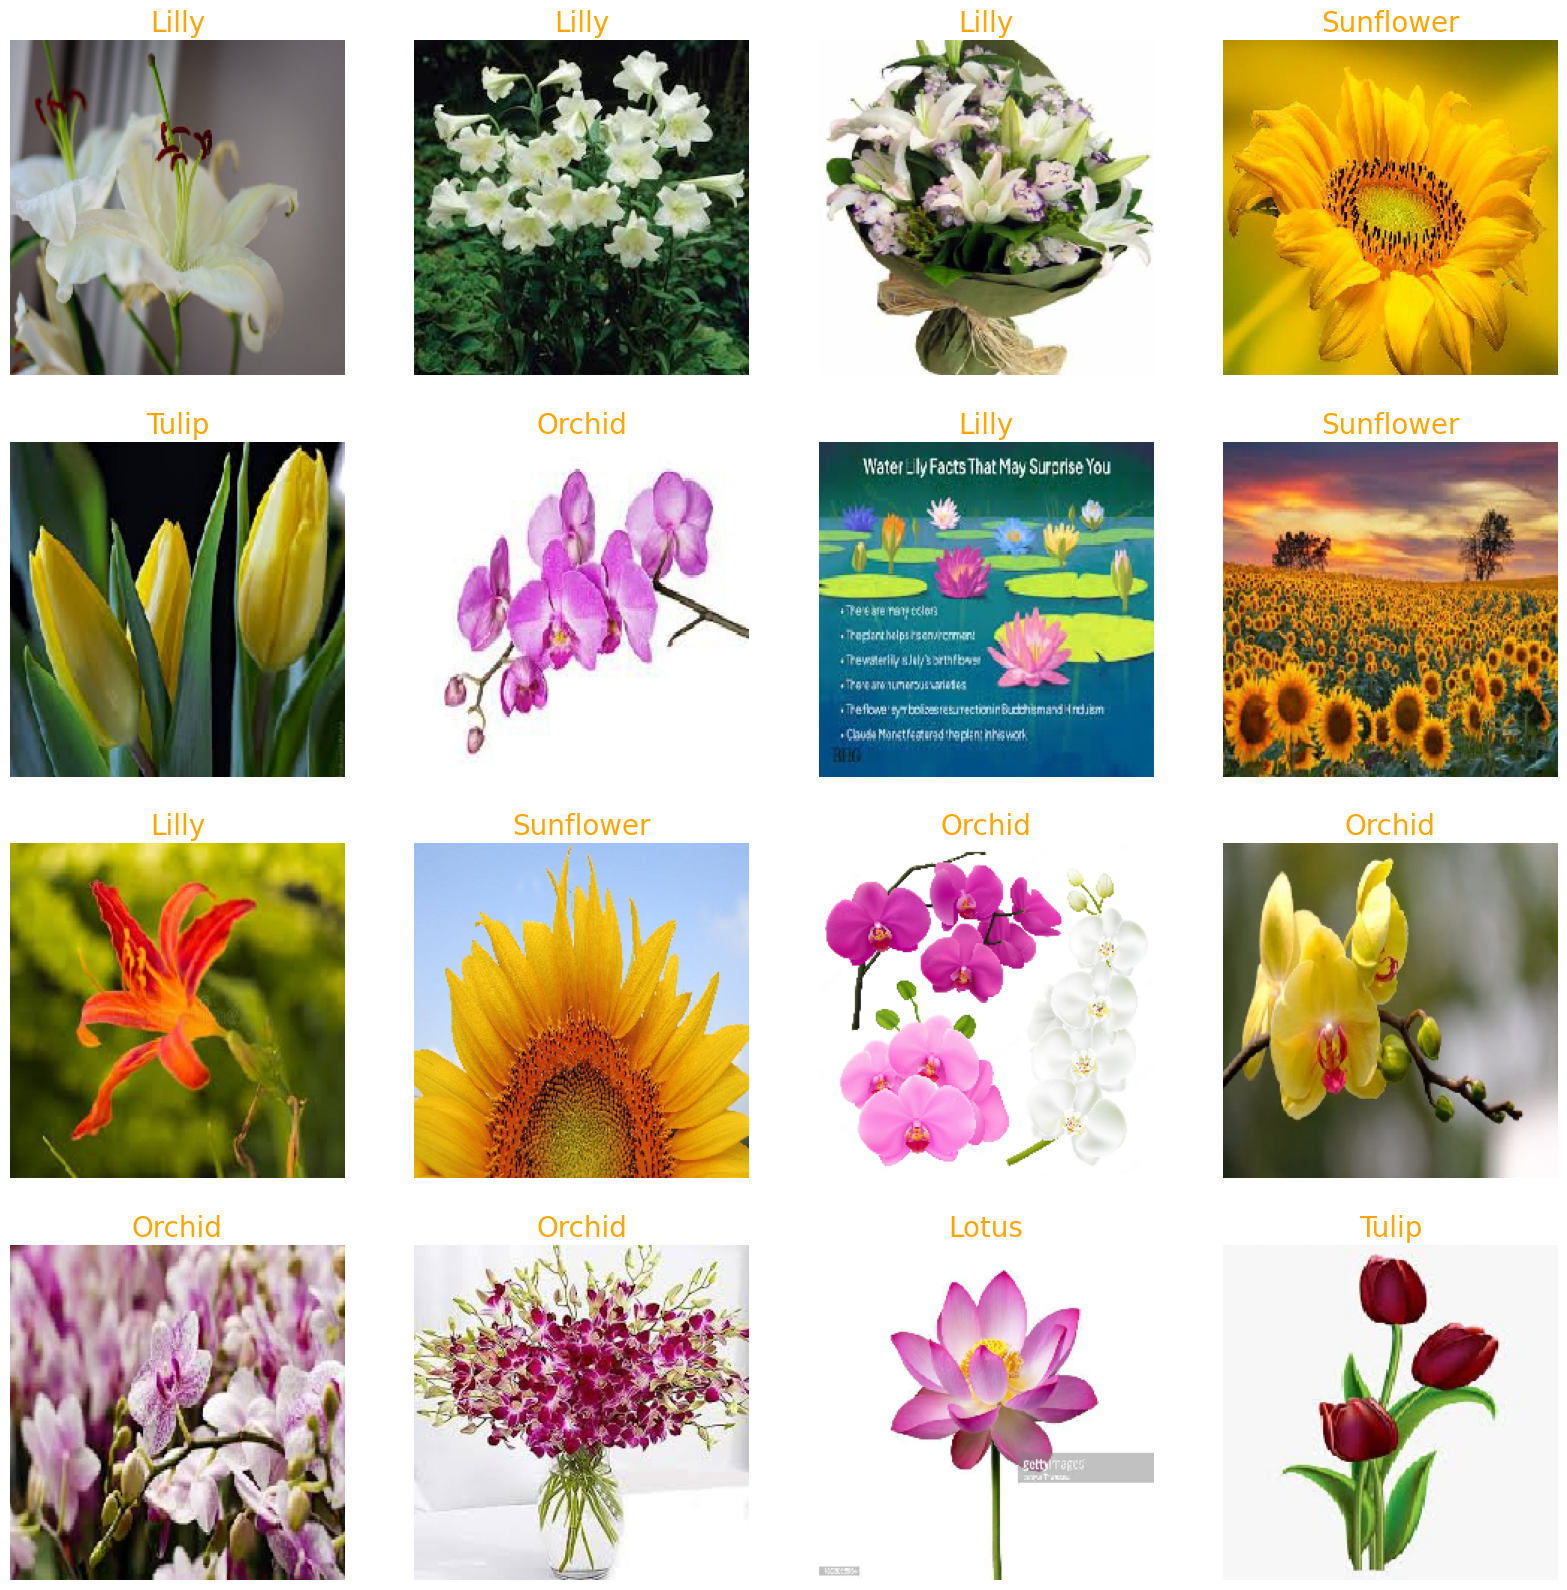

In [14]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color= 'orange' , fontsize = 20)
    plt.axis('off')
    
plt.show()

# Model Structure

In [15]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False , weights= 'imagenet' , input_shape = img_shape, 
                                               pooling = 'max')

for layer in base_model.layers:
    layer.trainable = False
    
    
model = Sequential([
    base_model ,
    BatchNormalization(axis= -1,momentum=0.99,epsilon=0.001),
    Dense(256 , activation = 'relu'),
    Dense(class_count , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## Iterate

In [16]:
checkpoint_path = "./cp.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path ,
                                                save_weights_only= True,
                                                verbose = 1)

num_epochs = 15
his = model.fit(x = train_gen , validation_data = valid_gen , epochs = num_epochs , verbose = 1,
               validation_steps = None , shuffle = False , callbacks = [cp_callback])

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6896 - loss: 0.8189
Epoch 1: saving model to ./cp.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.6900 - loss: 0.8180 - val_accuracy: 0.8780 - val_loss: 0.3604
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8991 - loss: 0.2828
Epoch 2: saving model to ./cp.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8991 - loss: 0.2828 - val_accuracy: 0.9060 - val_loss: 0.2797
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9326 - loss: 0.1975
Epoch 3: saving model to ./cp.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9326 - loss: 0.1975 - val_accuracy: 0.9380 - val_loss: 0.1983
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9465 - loss: 0.1509
Epoch 4: saving model to ./cp.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9465 - loss: 0.1509 - val_accuracy: 0.9400 - val_loss: 0.1845
Epoch 5/15
2

# Model Performance

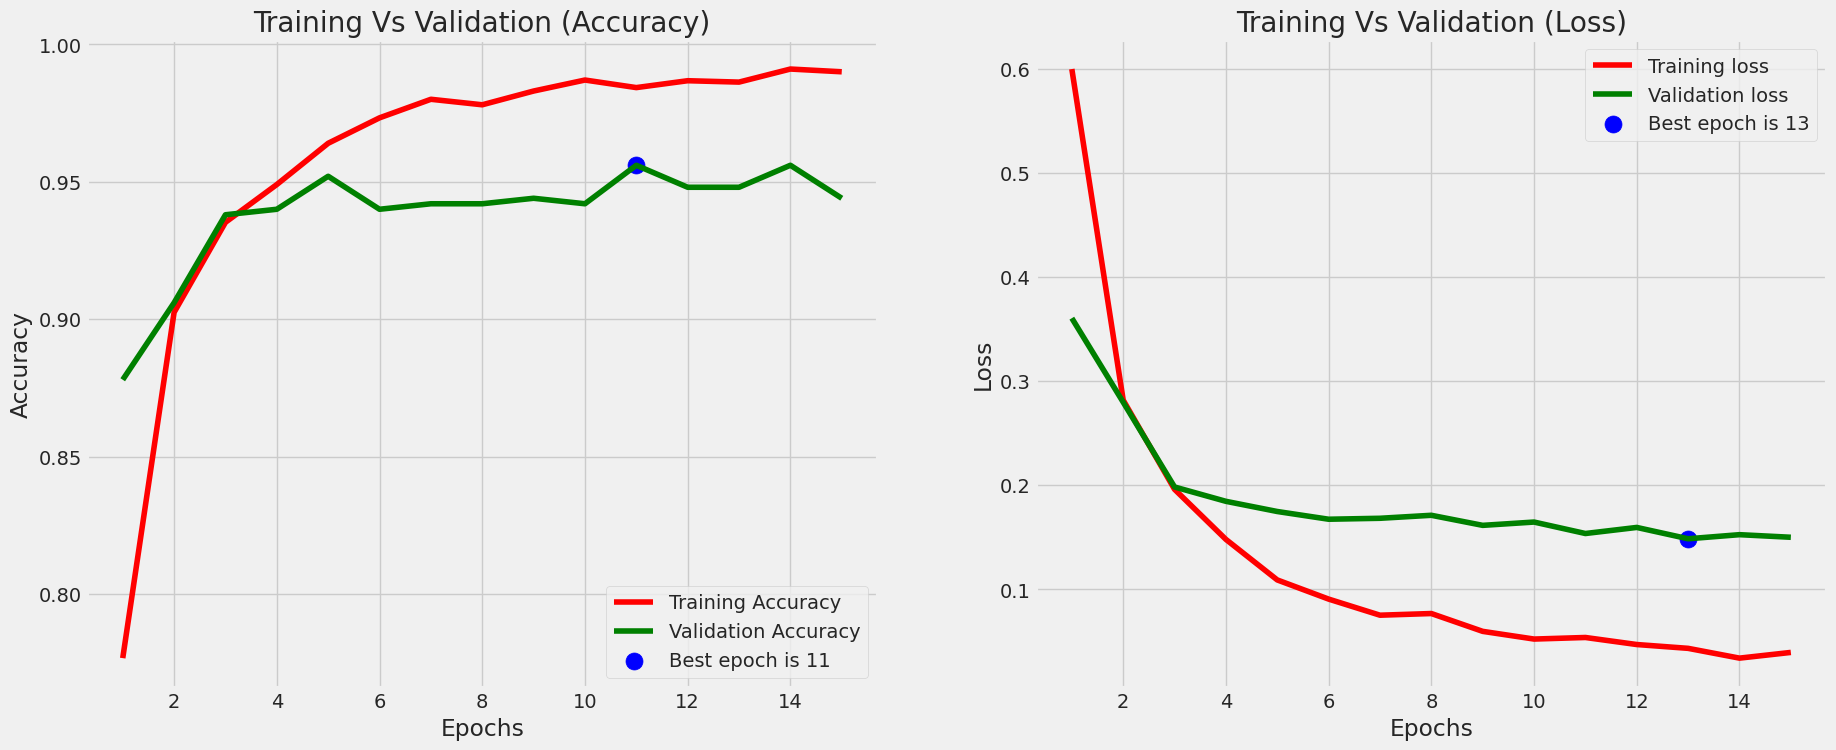

In [19]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

# Model Evaluation

In [22]:
train_score = model.evaluate(train_gen , steps= 16 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps= 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9910 - loss: 0.0299
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9277 - loss: 0.1551
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9634 - loss: 0.1250
Train Loss:  0.014752980321645737
Train Accuracy:  0.99609375
--------------------
Validation Loss:  0.16303303837776184
Validation Accuracy:  0.9375
--------------------
Test Loss:  0.19786030054092407
Test Accuracy:  0.94140625


# Model Prediction

## Confusion Matrix

In [26]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step


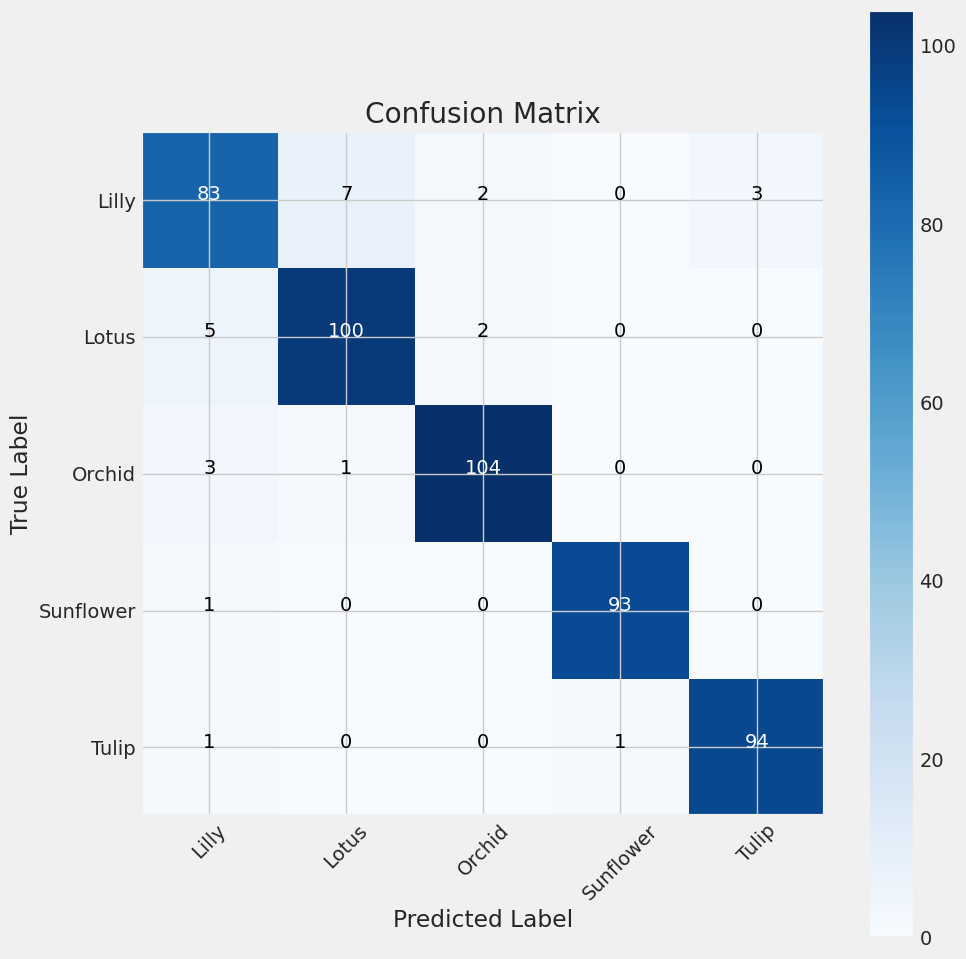

In [27]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

## Classification Report

In [28]:
print(classification_report(test_gen.classes , y_pred , target_names = classes))

              precision    recall  f1-score   support

       Lilly       0.89      0.87      0.88        95
       Lotus       0.93      0.93      0.93       107
      Orchid       0.96      0.96      0.96       108
   Sunflower       0.99      0.99      0.99        94
       Tulip       0.97      0.98      0.97        96

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

